# Book Recommender System

## Abstract

In this report, a dataset from the Book-Crossing community - containing 278,858 users providing 1,149,780 ratings (explicit / implicit) about 271,379 books - was explored, cleaned and prepared for modelling. The objective was to develop a model that can recommend readers new books based on their individual preferences (rating history). Therefore, several approaches and recommender models based on the idea of Collaborative Filtering have been tested: 1) Memory-based approaches with User-based and Item-based models using K-Nearest-Neighbors and 2) Model-based approaches with Item-based models using matrix factorization models like Singular Value Decomposition (SVD) and Non-negative matrix factorization (NMF).
As result the Singular Value Decomposition model outperformed the Non-negative matrix factorization (NMF) and both memory-based models. Hyper parameter tuning via Grid Search Cross Validation was applied to enhanced the Singular Value Decomposition model performance. The (slightly) optimized Singular Value Decomposition model was selected as the most viable option to make book recommendations. 

## 1. Introduction

Recommendation systems are becoming more and more common online these days. People rely on them to inform decisions on a daily basis like what to buy, movies to watch, music to listen to, and books to read. Readers are always looking for the next great book. The purpose of this study is to assist people in choosing new books to read.<br></br>
<span style="color:red">*need to finish this still*</span>

### 1.1 Background


"Collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems. Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books. 

Format: 
The Book-Crossing dataset comprises 3 tables.

**BX-Users**
Contains the users. Note that user IDs (`User-ID`) have been anonymized and map to integers. Demographic data is provided `Location`, `Age`) if available. Otherwise, these fields contain NULL-values.

**BX-Books**
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), i.e., small, medium, large. These URLs point to the Amazon web site.

**BX-Book-Ratings**
Contains the book rating information. Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0."

http://www2.informatik.uni-freiburg.de/~cziegler/BX/ 

### 1.2 Objective

The objective of this analysis is to:
+ provide a reliable and feasible algorithm to recommend new books to readers based on their reading history (incl. given ratings of each book)
+ and to build an app to deploy the recommender.

## 2. Data Understanding 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [ ]:
# Reading datasets (Priyanka)

items_df = pd.read_csv('/content/drive/MyDrive/Book reviews/BX_Books.csv', sep=';',error_bad_lines=False, encoding='latin-1', low_memory=False)
ratings_df = pd.read_csv('/content/drive/MyDrive/Book reviews/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding='latin-1', low_memory=False)
users_df = pd.read_csv('/content/drive/MyDrive/Book reviews/BX-Users.csv', sep=';',error_bad_lines=False, encoding='latin-1', low_memory=False)

users_df.columns = ['user_id', 'location', 'age']
items_df.columns = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
ratings_df.columns = ['user_id', 'isbn', 'rating']

### 2.1 Users dataset

In [ ]:
users_df.head(5)

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
print('Shape of users dataset (rows,columns):',users_df.shape)
print('Size of users dataset:',users_df.size)

Shape of users dataset (rows,columns): (278858, 3)
Size of users dataset: 836574


The User data set ('user_df') contains demographic information about the user. It includes 836.574 values, 278.858 rows/records and 3 columns, such as user Id, location and age.

In [ ]:
# Check for missing values
(users_df.isna().sum()/users_df.shape[0])*100

user_id      0.000000
location     0.000000
age         39.719857
dtype: float64

In [ ]:
users_df.isnull().sum()

user_id          0
location         0
age         110762
dtype: int64

Variable 'age' has 39.7% missing values (= 112.036 values).

In [ ]:
# check type for each variable
users_df.dtypes

user_id       int64
location     object
age         float64
dtype: object

In [ ]:
# summery statistics
users_df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,278858.0,139429.500000,80499.515020,1.0,69715.25,139429.5,209143.75,278858.0
age,168096.0,34.751434,14.428097,0.0,24.00,32.0,44.00,244.0


The summery statistics show that the variable 'age' includes outliers. The maximum is 244 years and the minimum age is 0 year. Both ages are impossible.

Text(0.5, 1.0, 'Find outliers in variable "age"')

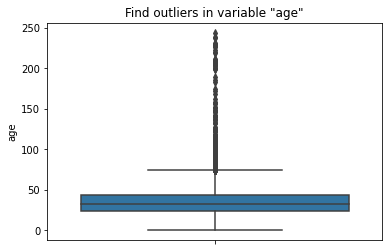

In [ ]:
# Take a closer look at the variable 'age" for ouliers
sns.boxplot(y=users_df["age"], data = users_df).set_title('Find outliers in variable "age"')

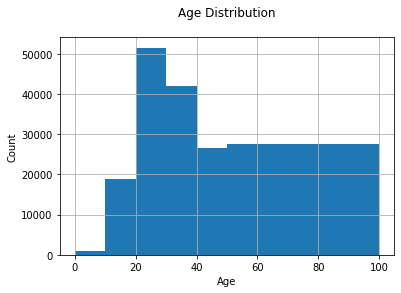

In [ ]:
# Check distribution of variable 'age' (in a certain range)

users_df.age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

The graph shows that people between 20-40 years are the most active users. 
As shown in the bar boxplot (and the summery statistics) the variable 'age' contains outliers since children under 6 years and people over 100 years probably don't give book ratings. 

### 2.2 Items dataset

In [ ]:
items_df.head(5)

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
print('Shape of items dataset (rows,columns):',items_df.shape)
print('Size of items dataset:',items_df.size)

Shape of items dataset (rows,columns): (271379, 8)
Size of items dataset: 2171032


The books data set ('books_df') contains 2,170.880 values, 271,360 rows/records and 8 columns with various information about books, such as: ISBN, Book title, book author, publisher and year of publication.


In [ ]:
# Check type for each variable
items_df.dtypes

isbn                   object
book_title             object
book_author            object
year_of_publication     int64
publisher              object
img_s                  object
img_m                  object
img_l                  object
dtype: object

In [ ]:
#check for null values
print("Check for Null values in books dataset")
items_df.isnull().sum()

Check for Null values in books dataset


isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
img_s                  0
img_m                  0
img_l                  0
dtype: int64

In [ ]:
# check for missing values
(items_df.isna().sum()/items_df.shape[0])*100

isbn                   0.000000
book_title             0.000000
book_author            0.000368
year_of_publication    0.000000
publisher              0.000737
img_s                  0.000000
img_m                  0.000000
img_l                  0.000000
dtype: float64

In [ ]:
items_df.isna().sum()

isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
img_s                  0
img_m                  0
img_l                  0
dtype: int64

The dataset has just a few missing values in the columns "book_author" (1), 'publisher' (2) and the column listing large images of the books (3)).

In [ ]:
# summery statistics
items_df.describe()

,year_of_publication
count,271379.000000
mean,1959.756050
std,258.011363
min,0.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2050.000000


The statistics show a minimum value of 0 and a maximum value of 2050 regarding the year of publication. Since both values are impossible, these are outliers that need to be treated later on.

### 2.3 Ratings data set

In [ ]:
ratings_df.head(5)

,user_id,isbn,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
print('Shape of ratings dataset (rows,columns):',ratings_df.shape)
print('Size of ratings dataset:',ratings_df.size)

Shape of ratings dataset (rows,columns): (1149780, 3)
Size of ratings dataset: 3449340


The ratings data set ('rating_df') contains a list of ratings that users have given to books. It includes 3,449.340 values, 1,149,780 row/records and 3 columns providing information about User ID, ISBN and Ratings of the book.

In [ ]:
# drop duplicates
ratings_df.drop_duplicates(inplace=True, keep='first') 

In [ ]:
# check for missing values
(ratings_df.isna().sum()/ratings_df.shape[0])*100

user_id    0.0
isbn       0.0
rating     0.0
dtype: float64

In [ ]:
# check type for each variable
ratings_df.dtypes

user_id     int64
isbn       object
rating      int64
dtype: object

In [ ]:
# summery statistics
ratings_df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1149780.0,140386.395126,80562.277718,2.0,70345.0,141010.0,211028.0,278854.0
rating,1149780.0,2.866950,3.854184,0.0,0.0,0.0,7.0,10.0


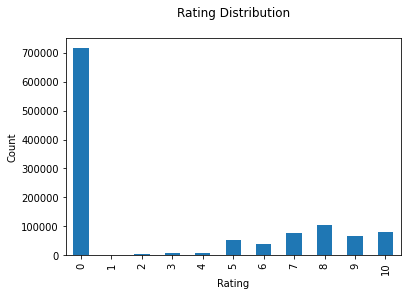

In [ ]:
# distribution variable 'rating'

ratings_df.rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Note: The variable rating includes explicit ratings, expressed on a scale from 1–10 (higher values denoting higher appreciation) and implicit rating (0). The majority of ratings is 0.

## 3. Data Preparation


### 3.1. Users Data Set

As noticed earlier, the variable 'age' in the Users data set contains missing values and outliers that need to be fixed. An appropriate age range seems to be 6 years (early readers) to 100 years (ambitions readers). The inconsistent values in the variable 'age' could just be replaced with the mean age value, but that would create a huge group of users with the same age. There are  112.036 missing values (see statistics earlier) plus 1274 outliers (see below). To create more precise values, the inconsistent values will be imputed with the mean age of each countries data.


In [ ]:
print("Users who are younger than 6 and older than 100 :",users_df.loc[(users_df.age>100) | (users_df.age<6),'age'].count())
users_df.loc[(users_df.age>100) | (users_df.age<6),'age'] = np.nan

Users who are younger than 6 and older than 100 : 1274


In [ ]:
# inconsistent values to NAN
users_df.loc[(users_df.age > 100) | (users_df.age < 6), 'age'] = np.nan

In [ ]:
# create new column called "country"
users_df['country']='Canada'
for i in users_df:
    users_df['country']=users_df.location.str.extract(r'\,+\s?(\w*\s?\w*)\"*$')   

In [ ]:
# quick check for Null values 
users_df.isnull().sum()

user_id          0
location         0
age         112036
country        368
dtype: int64

In [ ]:
# the new variable "country" contains missing values that will be set to "Unknown"
users_df.loc[users_df.country.isnull(),'country']='unknown'

In [ ]:
users_df.isnull().sum()

user_id          0
location         0
age         112036
country          0
dtype: int64

In [ ]:
# Find number of book readers in each country 
book_users = users_df.country.value_counts()
country = book_users.index.tolist()

In [ ]:
# define the range of age for users in each country
range_of_age = users_df.loc[users_df.country.isin(country)][['country','age']].groupby('country').agg(np.mean).to_dict()

#print(range_of_age)

In [ ]:
for k,v in range_of_age['age'].items():
    users_df.loc[(users_df.age.isnull())&(users_df.country== k),'age'] = v

In [ ]:
users_df.isnull().sum()

user_id       0
location      0
age         293
country       0
dtype: int64

In [ ]:
# Impute the left 342 Null values with the overall mean
users_df.age = users_df.age.fillna(users_df.age.mean())

In [ ]:
users_df.isnull().sum()

user_id     0
location    0
age         0
country     0
dtype: int64

Variable 'age' should be an integer (not a float).

In [ ]:
# Change type from float to integer
users_df['age'] = users_df['age'].astype(np.int64)

In [ ]:
users_df['age'].dtypes

dtype('int64')

In [ ]:
users_df['age'].describe()

count    278858.000000
mean         34.845918
std          10.705037
min           6.000000
25%          28.000000
50%          35.000000
75%          37.000000
max         100.000000
Name: age, dtype: float64

### 3.2 Items Data Set

The Item data set has outliers in the variable ''year_of_publication' and a few missing values in the columns 'publisher' and 'book_author'.

In [ ]:
# drop the irrelant variables (images)
items_df = items_df.drop(['img_s', 'img_m', 'img_l'], axis=1)

In [ ]:
items_df.isnull().sum()

isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
dtype: int64

**Variable 'year_of_publication':** The dataset was collected in 2004, so the data set should not contain books that were published after 2004. There are also some inconcistent values (strings and year dates from before the book printing was invented) that need to be further examined (see below).
The data type needs to be changed from float to integer.

In [ ]:
# print unique values in 'year of publication' (see 2 strings and several 0 values)
#print(sorted(items_df['year_of_publication'].unique())) this line is giving me an error
print(items_df['year_of_publication'].unique().tolist())

[2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994, 2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980, 1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974, 1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030, 1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934, 1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901, 2010, 1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378, 1919, 1922, 1897, 2024, 1376, 2037]


In [ ]:
items_df[items_df.year_of_publication =='Gallimard']

,isbn,book_title,book_author,year_of_publication,publisher


In [ ]:
items_df[items_df.year_of_publication =='DK Publishing Inc']

,isbn,book_title,book_author,year_of_publication,publisher


Note: The values for the variable "book_author" and "year_of publication" are twisted.

In [ ]:
# correct the twisted data entries
items_df.loc[items_df.isbn =='2070426769','year_of_publication']=2003
items_df.loc[items_df.isbn=='2070426769','book_author']='Gallimard'
items_df.loc[items_df.isbn=='0789466953','year_of_publication']=2000
items_df.loc[items_df.isbn=='0789466953','book_author']='DK Publishing Inc'
items_df.loc[items_df.isbn=='078946697X','year_of_publication']=2000
items_df.loc[items_df.isbn=='078946697X','book_author']='DK Publishing Inc'

In [ ]:
# Convert data type to integer
items_df['year_of_publication'] = pd.to_numeric(items_df['year_of_publication'].astype(int))

In [ ]:
items_df['year_of_publication'].dtypes

dtype('int64')

In [ ]:
# Replace inconsistent values (values below 1800 and above 2004 will be replaced with the mean value)
items_df.loc[(items_df['year_of_publication'] == 0)|(items_df['year_of_publication'] > 2004) | (items_df['year_of_publication'] < 1800), 'year_of_publication' ] = np.nan
items_df['year_of_publication'] = items_df['year_of_publication'].fillna(round(items_df['year_of_publication'].mean()))

In [ ]:
items_df.isnull().sum()

isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
dtype: int64

In [ ]:
items_df.describe().T

,count,mean,std,min,25%,50%,75%,max
year_of_publication,271379.0,1993.694792,8.076069,1806.0,1989.0,1995.0,2000.0,2004.0


**Variables 'publisher' and 'book_author':** Since the missing values of the these remaining variables are very few (just 3 values), they can just be dropped.

In [ ]:
# drop the 3 rows with missing values
items_df = items_df.dropna()

In [ ]:
items_df.isnull().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
dtype: int64

### 3.3 Ratings Data Set

The Rating data set has no missing values or obvious inconsistencies (except the implicit (0) ratings), therefore there is no need to clean it at this time.

### 3.4 Joining Data Sets

The three data sets are merged based on the variables 'user_id' and 'isbn' (as keys).

In [ ]:
users_ratings_df = pd.merge(users_df, ratings_df, on='user_id')
books_df = pd.merge(users_ratings_df, items_df, on='isbn')

In [ ]:
# make a copy
books_dfc = books_df.copy()

In [ ]:
books_dfc.head()

,user_id,location,age,country,isbn,rating,book_title,book_author,year_of_publication,publisher
0,2,"stockton, california, usa",18,usa,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,8,"timmins, ontario, canada",35,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,11400,"ottawa, ontario, canada",49,canada,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
3,11676,"n/a, n/a, n/a",30,unknown,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
4,41385,"sudbury, ontario, canada",35,canada,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada


### 3.5 Further Data Preparation

The dataset contains the variable 'location' and 'country'. That need to be cleaned. The variable 'location' contains three categories of information: city, state and country. For the further analysis the categories will be splitted in new variables and the missing locations will be replaced with "unknown" (like it was done for the variable 'country'). 

In [ ]:
location = books_dfc['location'].str.split(', ', n=2, expand=True)
location.columns = ['city', 'state', 'country']
location = location.fillna('unknown')

In [ ]:
books_dfc['city'] = location['city'] ;
books_dfc['state'] = location['state'] ;
books_dfc['country'] = location['country']

In [ ]:
books_dfc = books_dfc.drop(['location'], axis=1)

In [ ]:
# quick overview
books_dfc.head()

,user_id,age,country,isbn,rating,book_title,book_author,year_of_publication,publisher,city,state
0,2,18,usa,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,stockton,california
1,8,35,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,timmins,ontario
2,11400,49,canada,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,ottawa,ontario
3,11676,30,n/a,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,n/a,n/a
4,41385,35,canada,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,sudbury,ontario


In [ ]:
# Replace 'n/a'-values with 'unknown'
books_dfc.loc[books_dfc.country == 'n/a', 'country'] = 'unknown'
books_dfc.loc[books_dfc.country == 'n/a', 'city'] = 'unknown'
books_dfc.loc[books_dfc.country == 'n/a', 'state'] = 'unknown'

In [ ]:
# Quick check on shape and size of the books data set ('books_dfc')
print('Shape of Books dataset (rows,columns):',books_dfc.shape)
print('Size of Books dataset:',books_dfc.size)

Shape of Books dataset (rows,columns): (1031172, 11)
Size of Books dataset: 11342892


In [ ]:
# droping the same record 
books_dfc.drop_duplicates(['user_id','book_title'],inplace=True)

In [ ]:
# Quick check on shape and size of the books data set ('books_dfc')
print('Shape of Books dataset (rows,columns):',books_dfc.shape)
print('Size of Books dataset:',books_dfc.size)

Shape of Books dataset (rows,columns): (1026394, 11)
Size of Books dataset: 11290334


The Books data set contains 11.289.905 values, 1,026.355 rows/records and 11 columns.

In [ ]:
print('Number of ratings: %d\nNumber of books: %d\nNumber of users: %d' % (len(books_dfc), len(books_dfc['isbn'].unique()), len(books_dfc['user_id'].unique())))

Number of ratings: 1026394
Number of books: 269631
Number of users: 92107


In [ ]:
# quick check on missing values and data types
books_dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1026394 entries, 0 to 1031171
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   user_id              1026394 non-null  int64  
 1   age                  1026394 non-null  int64  
 2   country              1026394 non-null  object 
 3   isbn                 1026394 non-null  object 
 4   rating               1026394 non-null  int64  
 5   book_title           1026394 non-null  object 
 6   book_author          1026394 non-null  object 
 7   year_of_publication  1026394 non-null  float64
 8   publisher            1026394 non-null  object 
 9   city                 1026394 non-null  object 
 10  state                1026394 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 94.0+ MB


In [ ]:
# let's make another copy of the clean data set
books_dfcl=books_dfc.copy()

### 3.6 Review: Implicit and Explicit Ratings

The user has the possibility to rate a book from 1-10, we call those values in the data set explicit ratings. But it is expected that a user will rarely have read and rated every book in the data set. So not every book will have a rating. Hence, there are a lot of 0 ratings, called implicit ratings. Those implicit ratings can be a good indicator of the popularity of a book but they don't include statements about the liking of the book. 
    
The modelling will just focus on the explicit ratings.


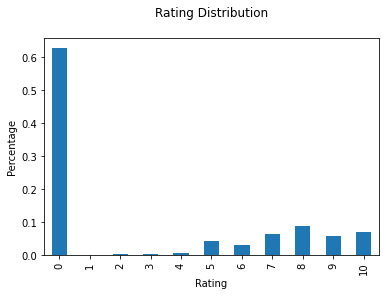

In [ ]:
# let's take a look at the percentage frequency of the ratings
books_dfcl.rating.value_counts(sort=False, normalize=True).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Percentage')
plt.show()


In [ ]:
# Seperate the explicit ratings represented by 1–10 and implicit ratings represented by 0
ratings_explicit_df= books_dfcl[books_dfcl['rating'] != 0]
ratings_implicit_df= books_dfcl[books_dfcl['rating'] == 0]


In [ ]:
print('Explicit ratings:', len(ratings_explicit_df))
print('Implicit ratings:', len(ratings_implicit_df))

Explicit ratings: 382200
Implicit ratings: 644194


## 4. Data Exploration 

### 4.1. Ratings

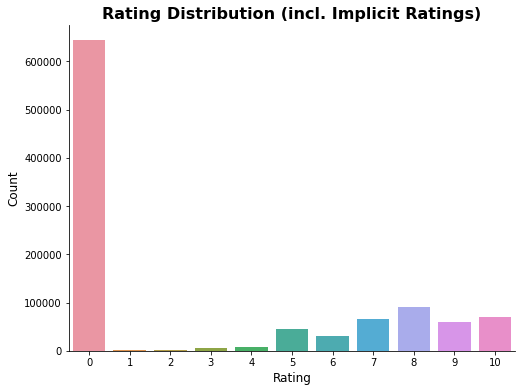

In [ ]:
# Distribution implicit and explicit ratings
plt.figure(figsize=(8,6))
#sns.countplot(x='rating', data=books_dfcl, palette='crest') (for Priyanka 'crest' pallete is not working)
sns.countplot(x='rating', data=books_dfcl)
sns.despine(top=True, right=True)
plt.title('Rating Distribution (incl. Implicit Ratings)', fontsize=16, weight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12);

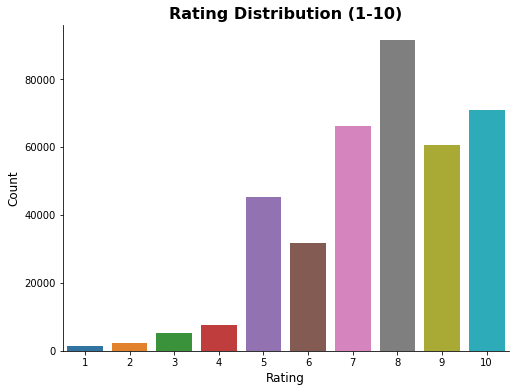

In [ ]:
# Distribution explicit ratings
plt.figure(figsize=(8,6))
#sns.countplot(x='rating', data=ratings_explicit_df, palette='crest')
sns.countplot(x='rating', data=ratings_explicit_df)
sns.despine(top=True, right=True)
plt.title('Rating Distribution (1-10)', fontsize=16, weight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12);

The graph above shows that users tended to rate books higher rather than lower. A rating of 8 is the most common rating. 

### 4. 2. Year of publication

In [ ]:
data = books_dfc['year_of_publication'].value_counts().head(50).reset_index()
data.columns=['year','count']
data.head()

,year,count
0,2002.0,91366
1,2001.0,79360
2,1999.0,74815
3,2003.0,72226
4,2000.0,71964


Text(0.5, 1.0, 'Years of publishing')

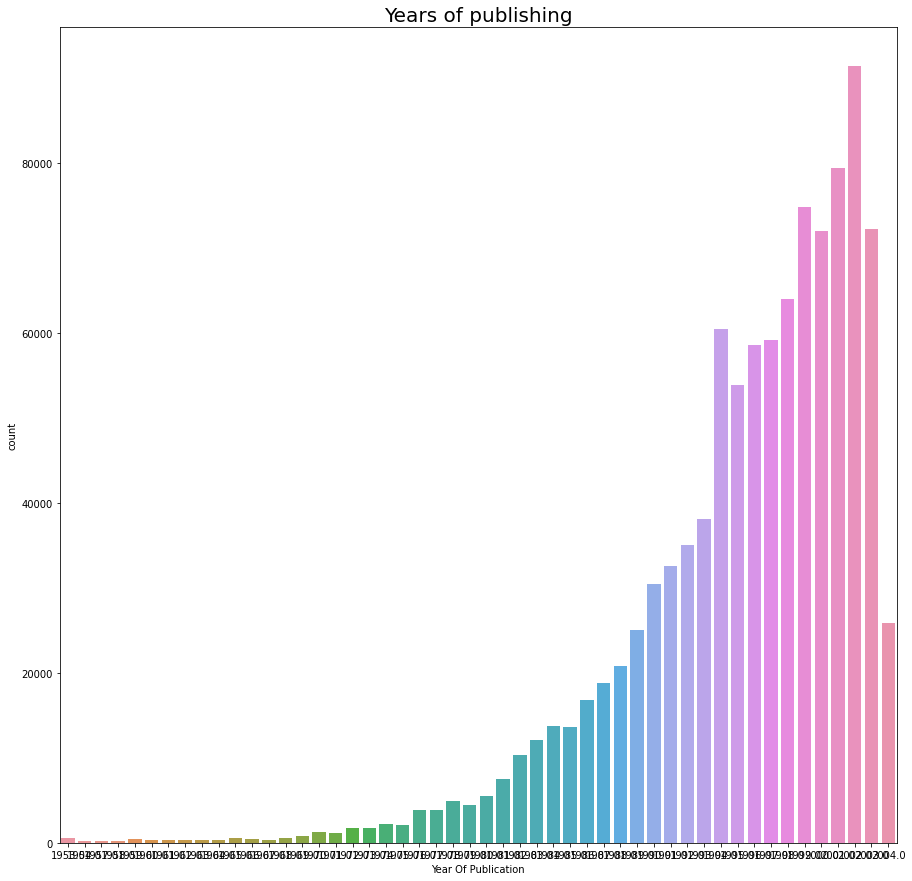

In [ ]:
plt.figure(figsize=(15,15))
sns.barplot(x='year',y='count',data=data)
plt.xlabel('Year Of Publication')
plt.title('Years of publishing',size=20)

### 4.3 Authors with most ratings (from 1-10)

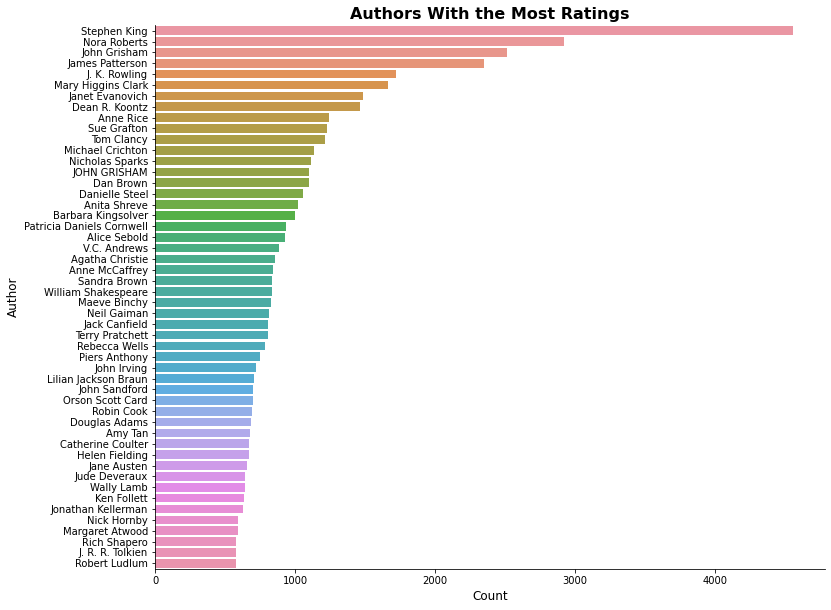

In [ ]:
data=ratings_explicit_df['book_author'].value_counts().head(50).reset_index()
data.columns=['author','count']
plt.figure(figsize=(12,10))
#sns.barplot(x='count',y='author',data=data, palette='crest')
sns.barplot(x='count',y='author',data=data)
sns.despine(top=True, right=True)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Author', fontsize=12)
plt.title('Authors With the Most Ratings', fontsize=16, weight='bold');

### 4.4 Books with most ratings (from 1-10)

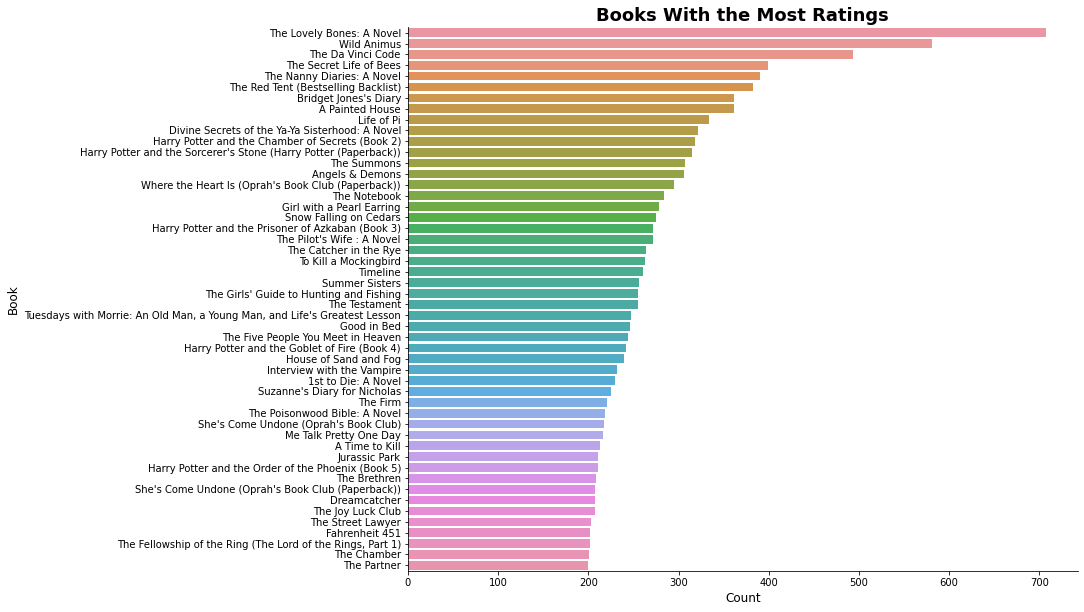

In [ ]:
data=ratings_explicit_df['book_title'].value_counts().head(50).reset_index()
data.columns=['book','count']
plt.figure(figsize=(12,10))
#sns.barplot(x='count',y='book',data=data, palette='crest')
sns.barplot(x='count',y='book',data=data)
sns.despine(top=True, right=True)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Book', fontsize=12)
plt.title('Books With the Most Ratings', fontsize=18, weight='bold');

### 4.5 Countries with most ratings

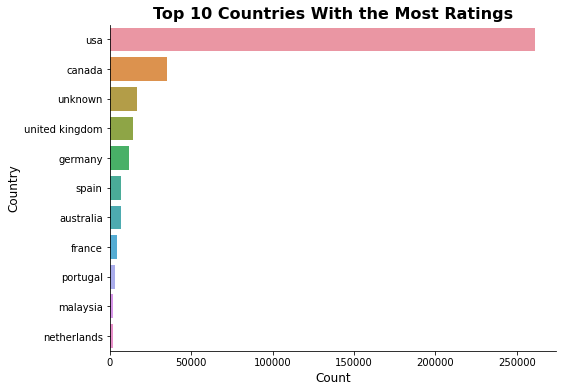

In [ ]:
data=ratings_explicit_df['country'].value_counts().head(11).reset_index()
data.columns=['country','count']
plt.figure(figsize=(8,6))
#sns.barplot(x='count',y='country',data=data, palette='crest')
sns.barplot(x='count',y='country',data=data)
sns.despine(top=True, right=True)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Top 10 Countries With the Most Ratings', fontsize=16, weight='bold');

### 4.6 Average Rating by Age

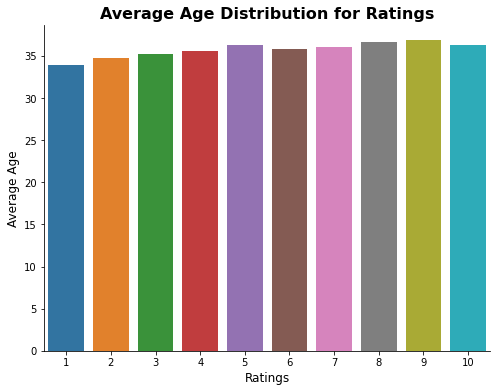

In [ ]:
data = ratings_explicit_df.groupby('rating')['age'].mean().reset_index()
data['rating']=data['rating'].astype(int)
plt.figure(figsize=(8,6))
#sns.barplot(x='rating',y='age',data=data, palette='crest')
sns.barplot(x='rating',y='age',data=data)
sns.despine(top=True, right=True)
plt.xlabel('Ratings', fontsize=12)
plt.ylabel('Average Age', fontsize=12)
plt.title('Average Age Distribution for Ratings', fontsize=16, weight='bold');

**How does each age group tend to rate their books?**
<br></br>
Is there a relationship between a user's age and the way they rate books?

In [ ]:
# making another copy of the explicit ratings data set
explic_rat=ratings_explicit_df.copy()

In [ ]:
bins = [0,20,40,60,80,110]
labels = ['0-19','20-39','40-59','60-79','80+']
explic_rat['age_group'] = pd.cut(explic_rat['age'], bins=bins, labels=labels, right=False)

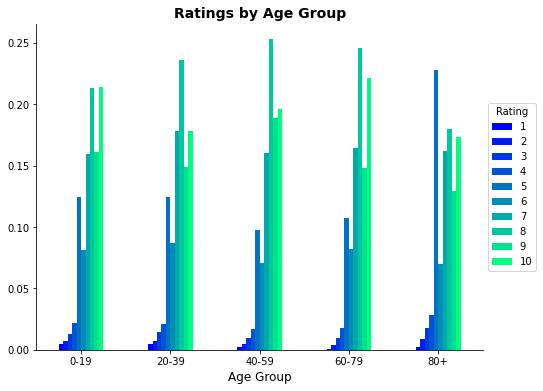

In [ ]:
crosstab1=pd.crosstab(explic_rat.age_group, explic_rat.rating, rownames=['Age Group'], colnames=['Rating'], margins=False, normalize='index')
#crosstab1.plot.bar(cmap='crest', figsize=(8,6))
crosstab1.plot.bar(cmap='winter', figsize=(8,6))
sns.despine(top=True, right=True)
plt.title('Ratings by Age Group', fontsize = 14, weight = 'bold')
plt.xlabel('Age Group', fontsize=12)
plt.xticks(rotation=0)
plt.legend(loc = 'center left', title='Rating', bbox_to_anchor=(1, 0.5));

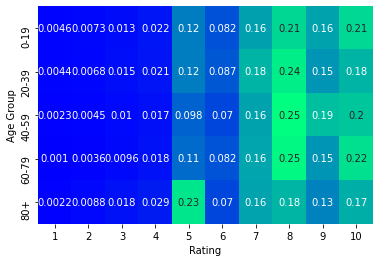

In [ ]:
#sns.heatmap(crosstab1, cmap="crest", annot=True, cbar=False);
sns.heatmap(crosstab1, cmap="winter", annot=True, cbar=False);

We can see from the heatmap that users 80 and over tend to assign lower ratings to their books than other age groups do.

In [ ]:
age_group=explic_rat['age_group'].value_counts().to_frame().reset_index().rename(columns={'index':'age_group','age_group':'Count'})

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
fig = go.Figure(data=[go.Scatter(
    x=age_group['age_group'], y=age_group['Count'],
    mode='markers',
    marker=dict(
        color=age_group['Count'],
        size=age_group['Count']*0.002,
        showscale=True
    ))])

fig.update_layout(autosize=False,width=900,height=800, title='Age Distribution',xaxis_title='Age Group',yaxis_title='Number Of Users',title_x=0.5)
fig.update_xaxes(categoryorder='category ascending')
fig.show()

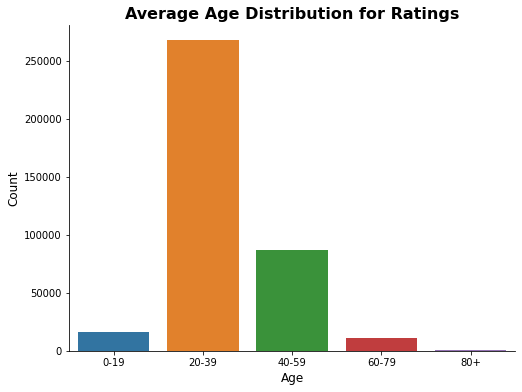

In [ ]:
data2 = explic_rat.groupby('age_group')['age'].count().reset_index()
#data2['rating']=data2['rating'].astype(int)
plt.figure(figsize=(8,6))
#sns.barplot(x='age_group',y='age',data=data2, palette='crest')
sns.barplot(x='age_group',y='age',data=data2)
sns.despine(top=True, right=True)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Average Age Distribution for Ratings', fontsize=16, weight='bold');

In [ ]:
users_ratings=ratings_explicit_df['user_id'].value_counts()

In [ ]:
# find users who have rated the most books on average
users_ratings_avg=ratings_explicit_df[['user_id','rating']].groupby(['user_id']).mean()

In [ ]:
users_ratings_avg['rating_count']=pd.DataFrame(ratings_explicit_df.groupby('user_id')['rating'].count())

Text(0.5, 0, 'Rating Count')

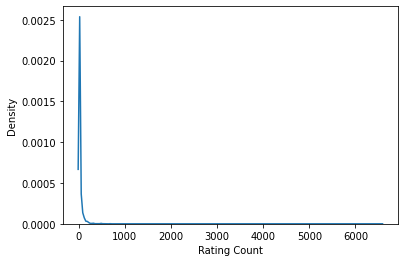

In [ ]:
sns.kdeplot(data=users_ratings_avg, x='rating_count')
plt.xlabel('Rating Count')

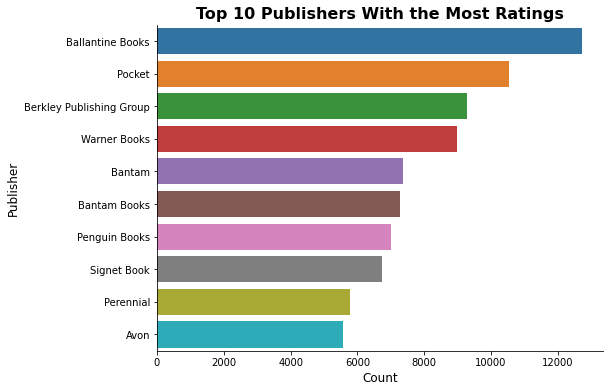

In [ ]:
# pie chart instead?
data1=ratings_explicit_df['publisher'].value_counts().head(10).reset_index()
data1.columns=['publisher','count']
plt.figure(figsize=(8,6))
#sns.barplot(x='count',y='publisher', data=data1, palette='crest')
sns.barplot(x='count',y='publisher', data=data1)
sns.despine(top=True, right=True)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Publisher', fontsize=12)
plt.title('Top 10 Publishers With the Most Ratings', fontsize=16, weight='bold');

*do certain age groups prefer certain publishers?*

In [ ]:
bins1 = [0,5,8,10]
labels1 = ['1-4','5-7','8-10']
explic_rat['rating_group'] = pd.cut(explic_rat['rating'], bins=bins1, labels=labels1, right=False)

## 5. Non-personalized recommendations: Popularity based recommender 

### 5.1 Popularity based recommender 

Non-personalized recommendations are made to all users. They basically work with the trend and they are not sensitive to the interests and tastes of a particular user. In the following the generally most liked popular books were identified, without taking the individual user preferences into account.

#### Most liked popular books 

In [ ]:
# first step: define most popular books
book_pop = ratings_explicit_df['book_title'].value_counts()

In [ ]:
print(book_pop.head(10))

The Lovely Bones: A Novel                          707
Wild Animus                                        581
The Da Vinci Code                                  493
The Secret Life of Bees                            399
The Nanny Diaries: A Novel                         390
The Red Tent (Bestselling Backlist)                383
Bridget Jones's Diary                              362
A Painted House                                    361
Life of Pi                                         334
Divine Secrets of the Ya-Ya Sisterhood: A Novel    322
Name: book_title, dtype: int64


In [ ]:
# find highest rated books on average
book_pop_avg=ratings_explicit_df[['book_title','rating']].groupby(['book_title']).mean()

In [ ]:
print(book_pop_avg.sort_values(by='rating', ascending=False).head(8))

                                                    rating
book_title                                                
Goodbye, Friend: Healing Wisdom for Anyone Who ...    10.0
Blind Justice                                         10.0
Eclipse 1999: the Last Total Eclipse of the Mil...    10.0
The Devil's Novice: The Eighth Chronicle of Bro...    10.0
The Small House at Allington (World's Classics S.)    10.0
Goofy Joins the Circus                                10.0
The Small Wood Shop (The Best of Fine Woodworking)    10.0
The Smiling Pets Recipe Book: 101 Easy Make Tre...    10.0


The extract of the sorted data frame above shows the top rated (most popular) books. The titles of the books look rather unfamiliar possibly due to very low numbers of ratings (which can skew the results). It can be assumed that a book that has been reviewed hundred of times has also non_perfect reviews. In contrary books with just a few rathings have a good chance of just positive ratings (=10) which pushes them to the top of the list. Therefore, in the next step just books that have been rated more than 100x were included in the calculation.

In [ ]:
# check only books that have been rated more than 100x 
book_review_pop=book_pop[book_pop > 100].index

In [ ]:
# take a subset of the df containing the explicit ratings by selecting only rows referring to 'book_review_pop'
book_pop_df=ratings_explicit_df[ratings_explicit_df['book_title'].isin(book_review_pop)]

In [ ]:
# find highest rated books on average
book_pop_avg2=book_pop_df[['book_title','rating']].groupby(['book_title']).mean()

In [ ]:
print(book_pop_avg2.sort_values(by='rating', ascending=False).head(7))

                                                      rating
book_title                                                  
The Two Towers (The Lord of the Rings, Part 2)      9.333333
The Return of the King (The Lord of the Rings, ...  9.297030
Harry Potter and the Goblet of Fire (Book 4)        9.107438
Harry Potter and the Sorcerer's Stone (Book 1)      9.052023
Harry Potter and the Prisoner of Azkaban (Book 3)   9.051471
Harry Potter and the Order of the Phoenix (Book 5)  9.047393
To Kill a Mockingbird                               8.969582


The table above lists the top 7 most and best rated books in the given dataset. Inspecting the result, it can be highlighted that the top books no longer have perfect ratings  (=10) but the titles are known and represent very popular books.

## 6. Personalized recommendations: Collaborative Filtering

There are two recommendation categories, the content based filtering and the the collaborative filtering:

+ **Content-based filtering models (CB)** are systems recommending items based on item descriptions and the user’s historical preference. Therefore ratings of the items by the users are not needed.

+ **Collaborative Filtering (CF)** are systems recommending items based on the observed behavior of the user (e.g. rating history). Hence, those systems require users to express opinions (e.g. through ratings) on items. 

CF frameworks can be further distinguished between Memory-based approaches and Model-based approaches:

+ **Memory-based approaches** calculate the similarities between users or items based on user-item rating pairs.
+ **Model-based approaches** use machine learning algorithms to estimate the ratings. 

Moreover, there are two different ways of filtering within the CF:

+ **User-based filtering systems (UBCF)** take a particular user and find users that are similar to that user based on similarity of ratings. They recommend items that are similar to the ones the users liked.

+ **Item-based filtering systems(IBCF)** take an item and find users who liked that item. They finds other items that those users or similar users also liked. So they take items and recommends other items.

Since the given data set contains ratings of items (books), the following analysis focuses on collaborative filtering. Different appoaches will be explored.
First, the memory-based approach will be tested, by evaluating a user-based filtering system and a item-based filtering system based on KNN. Second a collaborative model-based approach with item-based filtering will be exermined. The model-based approach facilitates machine learning techniques such as Singular Value Decomposition (SVD) and Matrix Factorization models to predict the user's rating on unknown items. 


For the modelling the Python library 'surprise' will be used. It was built for the implementation of recommendation systems and contains common algorithms like KNN, SVD and non-negative matrix factorization.

In [ ]:
# importing surprise and packages
!pip install surprise
from surprise import Reader, Dataset
from surprise import SVD, NMF, KNNBasic, model_selection, accuracy
from surprise.model_selection import cross_validate

### 6.1 Model preparation

The current data set contains 382.190 users, 149.440 books/items and 382.190 ratings. To reduce the dimensionality of the dataset and avoid running into memory error during modelling, the data set will just focus on users with more than 50 ratings. After setting the filter (see below) the data set has 1175 users, 86.013 books/items and 151.737 ratings.


In [ ]:
# current data set
book_final_data = ratings_explicit_df.copy()

book_final_data.shape

(382200, 11)

In [ ]:
book_final_data.size

4204200

In [ ]:
print('Number of ratings: %d\nNumber of books: %d\nNumber of users: %d' % (len(book_final_data), len(book_final_data['isbn'].unique()), len(book_final_data['user_id'].unique())))

Number of ratings: 382200
Number of books: 149446
Number of users: 68090


In [ ]:
# total rating counts
book_counts = book_final_data['rating'].value_counts()
user_counts = book_final_data['user_id'].value_counts()

In [ ]:
# check statistics of rating counts per user
user_counts.describe()

count    68090.000000
mean         5.613159
std         40.603824
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       6574.000000
Name: user_id, dtype: float64

As shown in the table (above) the majority of the users gave only one rating.

In [ ]:
# Let’s look at the top of the distribution
(user_counts.quantile(np.arange(.9, 1, .01)))

0.90     9.0
0.91    10.0
0.92    12.0
0.93    13.0
0.94    16.0
0.95    19.0
0.96    23.0
0.97    31.0
0.98    44.0
0.99    74.0
Name: user_id, dtype: float64

After taking a closer look at the top of the distribution, it can be stated that just 5% of the users made 19 or more ratings. 

In [ ]:
# set filter
book_final_data = book_final_data[book_final_data['user_id'].isin(user_counts[user_counts >= 50].index)]

In [ ]:
print('Number of ratings: %d\nNumber of books: %d\nNumber of users: %d' % (len(book_final_data), len(book_final_data['isbn'].unique()), len(book_final_data['user_id'].unique())))

Number of ratings: 151741
Number of books: 86017
Number of users: 1175


In [ ]:
book_final_data.shape

(151741, 11)

In [ ]:
book_final_data.size

1669151

In [ ]:
book_final_data.head(10)

,user_id,age,country,isbn,rating,book_title,book_author,year_of_publication,publisher,city,state
3,11676,30,unknown,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,n/a,n/a
8,116866,34,unknown,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,ottawa,","
21,110912,36,usa,0374157065,10,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,milpitas,california
26,197659,49,usa,0374157065,9,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,indiana,pennsylvania
31,11676,30,unknown,0399135782,9,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,n/a,n/a
32,29526,26,usa,0399135782,9,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,knoxville,tennessee
34,46398,37,usa,0399135782,9,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,san antonio,texas
54,230522,52,usa,0399135782,7,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,colorado springs,colorado
58,245827,34,unknown,0399135782,9,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,albuquerque,","
64,52614,33,usa,0425176428,8,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,toccoa,ga.


In [ ]:
book_final_data.to_csv(r'book_final_data.csv', index = False)

###  6.2  Memory based Filtering: KNN

Memory based algorithms use statistical techniques, like Cosine similarity or Pearson correlation coefficients, to calculate the closest users or items to make predictions.

+ Cosine Similarity: measures the cosine of the angle between two vectors of the item vectors of A and B. The closer the vectors, smaller will be the angle and higher the cosine similarity.

+ Pearson Similarity: means that the pearson coefficient between the two vectors is the similarity.

In the following, user-item and item-item model will be tested using both similarity metrics. The models will be compared and evaluated.

The cross_validate() function of Surprise will be applied to runs a 5-fold cross-validation procedure on the models.

In [ ]:
# Creating a 'Reader' object to set the limit of the ratings 
reader = Reader(rating_scale=(1, 10))

# Load the data into a 'dataset' object directly from the pandas dataframe
data = Dataset.load_from_df(book_final_data[['user_id','isbn','rating']], reader)

#### 6.2.1 User-based KNN 

In [ ]:
# Testing model with cosine similarity using 5-fold cross-validation procedure
sim_options = {
    'name': 'cosine',
    'user_based': 'True'
}

model_knn_u = KNNBasic(sim_options = sim_options)

cross_validate(model_knn_u, data, measures=['RMSE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9416  1.9492  1.9556  1.9566  1.9400  1.9486  0.0069  
Fit time          0.28    0.33    0.32    0.34    0.34    0.32    0.02    
Test time         0.48    0.48    0.49    0.46    0.50    0.48    0.01    


{'fit_time': (0.2771315574645996,
  0.3260831832885742,
  0.31974005699157715,
  0.33887434005737305,
  0.3358128070831299),
 'test_rmse': array([1.94160426, 1.94921673, 1.95558611, 1.95661262, 1.94002611]),
 'test_time': (0.47960948944091797,
  0.47975921630859375,
  0.48657655715942383,
  0.458892822265625,
  0.5036792755126953)}

In [ ]:
# testing model with Pearson similarity using 5-fold cross-validation procedure
sim_options = {
    'name': 'pearson',
    'user_based': 'True'
}

model_knn_u = KNNBasic(sim_options = sim_options)

cross_validate(model_knn_u, data, measures=['RMSE'], cv=5, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9208  1.9229  1.9133  1.9232  1.9219  1.9204  0.0037  
Fit time          0.33    0.42    0.40    0.40    0.41    0.39    0.03    
Test time         0.63    0.60    0.43    0.42    0.61    0.54    0.09    


{'fit_time': (0.3324880599975586,
  0.41775965690612793,
  0.40303516387939453,
  0.4023270606994629,
  0.40763115882873535),
 'test_rmse': array([1.92082903, 1.92286332, 1.91327039, 1.92318628, 1.92193889]),
 'test_time': (0.6308817863464355,
  0.5975334644317627,
  0.43097591400146484,
  0.419069766998291,
  0.6074783802032471)}

#### 6.2.2 Item-based KNN


In [ ]:
# testing model with cosine similarity using 5-fold cross-validation procedure
sim_options = {
    'name': 'cosine',
    'user_based': 'False'
}

model_knn_i = KNNBasic(sim_options = sim_options)
cross_validate(model_knn_i, data, measures=['RMSE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9545  1.9495  1.9548  1.9461  1.9477  1.9505  0.0035  
Fit time          0.26    0.31    0.32    0.32    0.33    0.31    0.03    
Test time         0.48    0.45    0.69    0.69    0.47    0.56    0.11    


{'fit_time': (0.256345272064209,
  0.31305885314941406,
  0.3234076499938965,
  0.31660890579223633,
  0.33018970489501953),
 'test_rmse': array([1.9544689 , 1.94951895, 1.95476193, 1.9461459 , 1.94767026]),
 'test_time': (0.4767293930053711,
  0.4548146724700928,
  0.6903314590454102,
  0.6860785484313965,
  0.47371506690979004)}

In [ ]:
# testing model with Pearson similarity using 5-fold cross-validation procedure
sim_options = {
    'name': 'pearson',
    'user_based': 'False'
}

model_knn_i = KNNBasic(sim_options = sim_options)
cross_validate(model_knn_i, data, measures=['RMSE'], cv=5, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9157  1.9173  1.9050  1.9279  1.9130  1.9158  0.0074  
Fit time          0.36    0.40    0.40    0.40    0.40    0.39    0.02    
Test time         0.43    0.45    0.46    0.45    0.45    0.45    0.01    


{'fit_time': (0.35877537727355957,
  0.39744019508361816,
  0.3958272933959961,
  0.3958923816680908,
  0.39697742462158203),
 'test_rmse': array([1.91573673, 1.91729109, 1.90502842, 1.92794666, 1.91304518]),
 'test_time': (0.4289073944091797,
  0.44801902770996094,
  0.459383487701416,
  0.4549560546875,
  0.4471707344055176)}

#### 6.2.3 Model Performance Evaluation

Evaluation: 
* User-based KNN model using Cosine similarity gives an average RMSE of: ..... over 5-folds.
* User-based KNN model using Pearson similarity gives an average RMSE of: .... over 5-folds.
* Item-based KKN model using Cosine similarity gives an average RMSE of:..... over 5-folds.
* Item-based KNN model using Pearson similarity gives an average RMSE of: .....over 5-folds.

The Pearson correlation coefficient leads to a higher accuracy of the models (the user-based and the item_based KNN model) than the cosine similarity. Overall the item-based model has a slightly better accuracy than the user-based model.

### 6.3 Model-based filtering: SVD and NMF

**Sparcity**: The calculations under 6.3.1 shows that the data set is despite the filter setting very sparce. Less than 1% of the data set includes any data. The spacity issue can cause problems for making predictions using KNN. KNN works better with dense data sets in which every item has been reviewed by several users, which ensures that the k-nearest neighbors are really similar to the selected user. Collaborative Item-based filtering using the Model-Based Approach can tackle the problem of sparcity. Model-Based approaches use machine learning techniques (such as Singular Value Decomposition (SVD) and Matrix Factorization models) to predict user ratings on unrated items. The follwoing recommender models will answer the question: “What books have a similar user-rating profile?"

+ SVD = Based recommendation System
+ NMF = Non-negative Matrix Factorization

#### 6.3.1. Sparcity

In [ ]:
# creating pivot table from "book_final_data"
book_rating=book_final_data.pivot(index='user_id',columns='book_title', values='rating')

In [ ]:
print(book_rating)

book_title   A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)  ...  Ã?Â?rger mit Produkt X. Roman.
user_id                                                                                                                 ...                                
254                                                       NaN                                                           ...                             NaN
638                                                       NaN                                                           ...                             NaN
1424                                                      NaN                                                           ...                             NaN
1733                                                      NaN                                                           ...                             NaN
1903                                                      NaN   

In [ ]:
# Count the occupied cells
sparsity_count = book_rating.isnull().values.sum()

In [ ]:
# Count all cells
full_count = book_rating.size

In [ ]:
# Find the sparsity of the DataFrame
sparsity = sparsity_count / full_count
print(sparsity)

0.9983751931078403


#### 6.3.2 SVD Model

+ Using cross-validation (5 folds)

In [ ]:
# Load SVD algorithm
model_SVD = SVD()

# Train on books dataset
model_selection.cross_validate(model_SVD, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5309  1.5285  1.5253  1.5226  1.5291  1.5273  0.0030  
Fit time          7.97    7.96    8.05    7.85    7.84    7.94    0.08    
Test time         0.27    0.25    0.59    0.25    0.25    0.32    0.14    


{'fit_time': (7.965188980102539,
  7.964080095291138,
  8.054777383804321,
  7.8512797355651855,
  7.840428113937378),
 'test_rmse': array([1.53090175, 1.52854924, 1.52532212, 1.52262646, 1.52913327]),
 'test_time': (0.27148962020874023,
  0.25374269485473633,
  0.591841459274292,
  0.2457866668701172,
  0.24868512153625488)}

+ Using test-train split

In [ ]:
# set test set to 20%
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

In [ ]:
# Instantiate the SVD model.
model_SVD = SVD()

# Train the algorithm on the training set, and predict ratings for the test set
%time model_SVD.fit(trainset)
predictions = model_SVD.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

CPU times: user 7.79 s, sys: 12.8 ms, total: 7.81 s
Wall time: 7.84 s
RMSE: 1.5319


1.53188319058389

#### 6.3.2. NMF Model

In [ ]:
# Load NMF algorithm
model_NMF = NMF()
# Train on books dataset
%time model_selection.cross_validate(model_NMF, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.4229  2.4507  2.4397  2.4411  2.4770  2.4463  0.0178  
Fit time          14.73   14.91   14.75   14.49   14.76   14.73   0.13    
Test time         0.57    0.28    0.20    0.21    0.20    0.29    0.14    
CPU times: user 1min 17s, sys: 291 ms, total: 1min 17s
Wall time: 1min 17s


{'fit_time': (14.730842113494873,
  14.908897399902344,
  14.748953104019165,
  14.490985631942749,
  14.760939836502075),
 'test_rmse': array([2.42286168, 2.45070242, 2.4396592 , 2.44110666, 2.47702182]),
 'test_time': (0.572934627532959,
  0.276078462600708,
  0.19852876663208008,
  0.20770525932312012,
  0.19653916358947754)}

#### 6.3.3 Model Performance Evaluation

+ Using the cross-validation technique, the SVD model gives an average RMSE of ...... over 5-folds.
+ Using a 80% train-test split, the SVD model gives a RMSE of .....   

+ Using the cross-validation technique, the NMF model gives an average RMSE of ...... over 5-folds.

The Singular Value Decomposition (SVD) outperformed the Non-negative matrix factorization (NMF) and has also shown more accurate results than the memory-based models. 

#### 6.3.4 Optimisation of SVD Model

In the following, the Grid Search Cross Validation method from the Surprise libary will be used to investigate if the predictions of the SVD model can be further improved by optimizing the algorithm hyperparameters. Grid Search Cross Validation computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. 

Grid Search Cross Validation goes through all combinations of parameters (within a given range) and reports the best- performing parameters for any accuracy measure (averaged over the different folds).

Parameters:

+ n_factors: the number of factors
+ n_epochs: the number of iteration of the SGD procedure
+ lr_all: the learning rate for all parameters
+ reg_all: the regularization term for all parameters


In [ ]:
# Remake the train/test sets, keeping 20% for testing
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

In [ ]:
from surprise.model_selection import GridSearchCV

In [ ]:
# param_grid = {'n_factors': [80,100,120],
#               'lr_all': [0.001,0.005, 0.01],
#               'reg_all': [0.01, 0.02, 0.04]}

# gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# # Fit the gridsearch result on the entire dataset
# %time gs.fit(data)

# # Return best
# print(gs.best_score['rmse'])
# print(gs.best_params['rmse'])

In [ ]:
# model = gs.best_estimator['rmse']

In [ ]:
# # cross validate
# model_selection.cross_validate(model_SVD, data, measures=['rmse', 'mae'], cv=5, verbose=True)

In [ ]:
# Use the new parameters with the training set
model_SVD = SVD(n_factors=80, lr_all=0.005, reg_all=0.04)
%time model_SVD.fit(trainset) 
test_pred = model_SVD.test(testset)

CPU times: user 6.76 s, sys: 11 ms, total: 6.77 s
Wall time: 6.78 s


In [ ]:
print("SVD : Test Set")
accuracy.rmse(test_pred, verbose=True)

SVD : Test Set
RMSE: 1.5140


1.5139970349610985

Evaluation: The mean RSME using the optimized parameters (identified via Grid Search CV) is .... over 5 folds. 
The model has slightly improved. The resulting RSME of .... shows a higher accuracy compared to the unoptimized SVD model with an RSME of.... 

### 6.4 Testing the Outputs (ratings and recommendations)

In the following, the SVD model was tested with 2 randomly selected users:
+ User1: user_i: 75819 for the item/book with the isbn: 0440234743. The user has rated the item with 7, our model predicts 7.63.
+ User2: user_i: 193529 for the item/book with the isbn: 0440234743. The user has rated the item with 7, our model predicts 7.51.

In [ ]:
# Trial 1: get a prediction for specific user
u_id = 75819  
i_id = '0440234743' 


pred = model_SVD.predict(u_id, i_id, verbose=True)

user: 75819      item: 0440234743 r_ui = None   est = 7.46   {'was_impossible': False}


In [ ]:
# Trial 2: get a prediction for specific user
u_id = 193529  
i_id = '0440234743' 


pred = model_SVD.predict(u_id, i_id, verbose=True)

user: 193529     item: 0440234743 r_ui = None   est = 7.58   {'was_impossible': False}


The following function is used to get the top book recommendations for each user:

In [ ]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for u_id, i_id, true_r, est, _ in predictions:
        top_n[u_id].append((i_id, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for u_id, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[u_id] = user_ratings[:n]
        
    
    return top_n

Let's get the Top 10 recommended books for each user_id in the test set.

In [ ]:
pred = model_SVD.test(testset)
top_n = get_top_n(pred)

In [ ]:
top_n


defaultdict(list,
            {65258: [('0345350804', 8.056736964998318),
              ('0028604032', 7.8842633328044025),
              ('0345368932', 7.744161661836422),
              ('0671656414', 7.711595345687438),
              ('0060971479', 7.707447399096319),
              ('0684865742', 7.696849742300227),
              ('0671027360', 7.679979588820611),
              ('006098824X', 7.67521381782961),
              ('1568821042', 7.598665206941813),
              ('0486240649', 7.476615498990591)],
             250709: [('0345350472', 5.805700114737736),
              ('0425147363', 5.651694205620148),
              ('0399148841', 5.553028758399736),
              ('0812568710', 5.524474337941762),
              ('067173458X', 5.482952658560085),
              ('1403300674', 5.463053044480974),
              ('4770029489', 5.463053044480974),
              ('0517705435', 5.463053044480974),
              ('0553562819', 5.463053044480974),
              ('0679887512', 5.4630

In [ ]:
import json
json.dump(top_n, open(r"top_n.jsn","w"))

In [ ]:
def get_reading_list(userid):
    
    # user_id is the 13618
    ratings = book_final_data.loc[book_final_data['user_id'] == userid]
    # obtain the required data of the selected user
    ratings=ratings[['book_title', 'rating']]
    if ratings.empty:
        print('Sorry your recommendation bucket is empty as you did not rate any books yet')
    else:
        df_reset=ratings.set_index('book_title')
        print("Your reading history: \n", df_reset.sort_values(by='rating', ascending=False).head(15))
        
    print("\n\nTop 10 recommended books for you: \n")
    reading_list = defaultdict(list)
    top_n = get_top_n(predictions, n=10)
    for n in top_n[userid]:
        book, rating = n
        title = book_final_data.loc[book_final_data.isbn==book].book_title.unique()[0]
        reading_list[title] = rating
        
    example_reading_list = reading_list.items()
    df = pd.DataFrame([(k,v) for k, v in example_reading_list], columns = ["book_name","rating"])
    df_set=df.set_index('book_name')
    df_set1=df_set.sort_values(by='rating', ascending=False).head(5)
    return reading_list

In [ ]:
# Let's take a random look at user_id=11676 from the testset
example_reading_list = get_reading_list(userid=11676)
for book, rating in example_reading_list.items():
    print(f'{book}: {rating}')

Your reading history: 
                                                     rating
book_title                                                
Second Nature                                           10
Fluttery Butterflies: Includes 20 Glitter Tatto...      10
The Emergency Room : Lives Saved and Lost - Doc...      10
Find Waldo Now!                                         10
Blood Work (Blood Work)                                 10
TV Troubl-Trol: Man St                                  10
The Big Dig (Carlotta Carlyle)                          10
Elliott Roosevelt's Murder at the President's D...      10
The Chase                                               10
The Veteran                                             10
The Beach Club : A Novel                                10
Dead Souls (St. Martin's Minotaur Mysteries)            10
A Comedy of Heirs (Torie O'Shea Mysteries (Pape...      10
Eleven Hours                                            10
Tooth and Nail (Detective John R

Sources:
+ https://surprise.readthedocs.io/en/stable/getting_started.html#basic-usage
+ https://www.analyticsvidhya.com/blog/2016/06/quick-guide-build-recommendation-engine-python/